In [75]:
# Requirements 
# !pip3 install pandas numpy seaborn
import pandas as pd
import numpy as np
import math
import seaborn as sns

# Importing the data

In [14]:
# dataset for October
# oct_df = pd.read_csv('2019-Oct.csv', header='infer', parse_dates=['event_time'], date_parser=pd.to_datetime)
# dataset for Nobember  # TODO: IMPORTANT remove nrows to consider the full dataset
nov = pd.read_csv('2019-Nov.csv', nrows=100000, header='infer', parse_dates=['event_time'], date_parser=pd.to_datetime)

In [4]:
nov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   event_time     1000 non-null   datetime64[ns, UTC]
 1   event_type     1000 non-null   object             
 2   product_id     1000 non-null   int64              
 3   category_id    1000 non-null   int64              
 4   category_code  617 non-null    object             
 5   brand          819 non-null    object             
 6   price          1000 non-null   float64            
 7   user_id        1000 non-null   int64              
 8   user_session   1000 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 70.4+ KB


In [5]:
#taking single event 
allType = pd.unique(nov['event_type'])
# this variable tells us that for november we have got 3 different events
allType

array(['view', 'cart', 'purchase'], dtype=object)

In [6]:
nov.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00+00:00,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00+00:00,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01+00:00,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01+00:00,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01+00:00,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [26]:
# number of operation per each user
# could be useful for RQ7
a = nov.groupby('user_id').event_type.count()
a.to_frame().head()

,event_type
user_id,
436701163,1
512370912,5
512376444,4
512416379,15
512436886,6


In [33]:
# Categories are composed of multiple subcategories, from NaN up to 4
nov_categories = nov.copy()
# nov_categories['category_code'].dropna().str.split('.', expand=True)
nov_categories['category_code'].str.split('.', expand=True).drop_duplicates().sort_values(
    by=list(range(4)), ascending=True
)

,0,1,2,3
90,accessories,bag,None,None
259,apparel,costume,None,None
53,apparel,jeans,None,None
197,apparel,shirt,None,None
803,apparel,shoes,keds,None
890,apparel,shoes,moccasins,None
184,apparel,shoes,None,None
409,apparel,trousers,None,None
52,apparel,tshirt,None,None
938,apparel,underwear,None,None


# RQ1

A marketing funnel describes your customer’s journey with your e-commerce. 

It may involve different stages, beginning when someone learns about your business, when he/she visits your website for the first time, to the purchasing stage, marketing funnels map routes to conversion and beyond.

Suppose your funnel involves just three simple steps: 

1) view, 
2) cart, 
3) purchase. 


- Which is the rate of complete funnels?


- What’s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).


- How many times, on average, a user views a product before adding it to the cart?


- What’s the probability that products added once to the cart are effectively bought?


- What’s the average time an item stays in the cart before being removed?


- How much time passes on average between the first view time and a purchase/addition to cart?

## Which is the rate of complete funnels? 

We should sort by event time, consider user id, product id and event type


Theoretically if user viewed a product put in into the cart another day and purchased another day the funnel is still complete, only order matters

There are inconsistent funnels where after viewing person can buy it without putting into a cart -> complete funnels are the ones that lead to a purchase

In [53]:
# Assume a compelte funnel is any funnel leading to a purchase, even if cart step has been skipped
complete_funnel = 0  # implies VIEW -> ... -> PURCHASE
product_user_pairs = 0  # total number of user-product interractions
for _, user_product_group in nov_sub_funnel.groupby(['user_id', 'product_id']):
    user_product_event = user_product_group.sort_values(
        by=['event_time']
    )[['event_type']].drop_duplicates(keep='last')
    # calculate all purchases in case if in one session person does two purchases one by one
    purchase_events = user_product_event['event_type'].isin(['purchase']).sum()
    if purchase_events > 0:
        complete_funnel += purchase_events
    product_user_pairs += max(purchase_events, 1)
print(f"Complete funnels: {complete_funnel} out of {product_user_pairs}")
print(f"Rate of complete funnels: {int(round(complete_funnel / product_user_pairs, 2) * 100)}%")

Complete funnels: 168 out of 10001
Rate of complete funnels: 2%


In [50]:
# TODO: optimize code and rewrite it on pandas without a loop?

In [212]:
#other idea for funnels
#check if a user has (view,cart,purchase) for a product

#try to reduce the number of rows by taking only users wich compair
#more then 2 times
sub_user_funnel 

,event_type,product_id,user_session,user_id
0,view,1003461,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,520088904
1,view,5000088,8e5f4f83-366c-4f70-860e-ca7417414283,530496790
2,view,17302664,755422e7-9040-477b-9bd2-6a6e8fd97387,561587266
3,view,3601530,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,518085591
4,view,1004775,313628f1-68b8-460d-84f6-cec7a8796ef2,558856683
...,...,...,...,...
67501961,view,1801766,dd9470f9-c563-4290-8dd4-b3a60ad6ef27,579969533
67501964,view,12711053,8da3b70a-13fd-4769-8e7e-3f9c289fe830,552749164
67501966,view,1005174,180a7f1f-ed0c-485a-b145-a980716d6abb,579969525
67501971,view,8800713,e4bfecbc-8a99-437d-b6b8-b5dfbd87bf78,579968742


## What’s the operation users repeat more on average within a session? 
Produce a plot that shows the average number of times users perform each operation (view/etc).

In [112]:
session_operations = nov.groupby(
    ['user_session', 'event_type']
).event_type.count().to_frame().rename(
    columns={'event_type': 'n_events'}
)
session_operations = session_operations.reindex(
    pd.MultiIndex.from_product(
        [session_operations.index.levels[0], ['view', 'cart', 'purchase']], 
        names=['user_session', 'event_type']
    ),
    fill_value=0
)
session_operations = session_operations.reset_index()
session_operations.head(20)

,user_session,event_type,n_events
0,000201a5-a363-4fd2-9228-ab8148c528c1,view,1
1,000201a5-a363-4fd2-9228-ab8148c528c1,cart,0
2,000201a5-a363-4fd2-9228-ab8148c528c1,purchase,0
3,00020305-cbad-48d4-8ead-d9bd2fae9678,view,2
4,00020305-cbad-48d4-8ead-d9bd2fae9678,cart,0
5,00020305-cbad-48d4-8ead-d9bd2fae9678,purchase,0
6,0008f678-9531-4d1e-a22a-4b39d1b7e79c,view,1
7,0008f678-9531-4d1e-a22a-4b39d1b7e79c,cart,0
8,0008f678-9531-4d1e-a22a-4b39d1b7e79c,purchase,0
9,00092ee4-0243-4bda-8ffd-5b905a086c7f,view,5


In [113]:
# Average number of times users perform each operation (within a session)
session_operations_avg = session_operations.groupby(
    ['event_type']
).n_events.mean().to_frame().reset_index().sort_values(by=['n_events'], ascending=False)
session_operations_avg.head(5)

,event_type,n_events
2,view,3.916951
1,purchase,0.057134
0,cart,0.043754


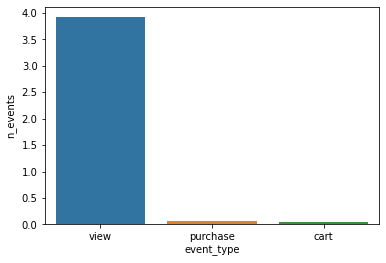

In [114]:
_ = sns.barplot(data=session_operations_avg, x="event_type", y="n_events")

## How many times, on average, a user views a product before adding it to the cart?

## What’s the probability that products added once to the cart are effectively bought?

## What’s the average time an item stays in the cart before being removed?

## How much time passes on average between the first view time and a purchase/addition to cart?

# RQ2

In [ ]:
#we remove obj without categories

In [294]:
#subsetting to obtai a faster solution
subRQ2 = nov[['event_type','product_id','category_code']]

In [295]:
#removing NA
subRQ2 = subRQ2.dropna()

In [211]:
subRQ2.head()

,event_type,product_id,category_code,product_id
0,view,1003461,electronics.smartphone,1003461
1,view,5000088,appliances.sewing_machine,5000088
3,view,3601530,appliances.kitchen.washer,3601530
4,view,1004775,electronics.smartphone,1004775
5,view,1306894,computers.notebook,1306894


In [201]:
#subsetting of sales 
sales = subRQ2[subRQ2['event_type']=='purchase']


In [282]:
sales.head()

,event_type,product_id,category_code
107,purchase,13200605,furniture
168,purchase,1005161,electronics
707,purchase,1004856,electronics
939,purchase,1801881,electronics
942,purchase,5800823,electronics


In [202]:
#rename categpories
#extracting categories from the dataset

#TODO implement pandas function 
sales['category_code'] = [el.split('.')[0] for el in list(sales['category_code']) if type(el) == str]

<ipython-input-202-c6c4eb04b3c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales['category_code'] = [el.split('.')[0] for el in list(sales['category_code']) if type(el) == str]


In [217]:
#in this way we directly count 
number_of_sales = sales.groupby('category_code').product_id.count()

In [291]:
#RQ2.0
#number of product sold for each categories
number_of_sales
number_of_sales.sort_values(ascending=False)

#TODO plot 

category_code
electronics     493639
appliances       99026
computers        34477
apparel          14215
furniture        11542
auto             10719
construction      8699
kids              6166
accessories       2154
sport             1489
medicine           344
stationery         191
country_yard        60
Name: product_id, dtype: int64

#most visited categories
some thing of sales, but now we are interested in view not in purchase

In [205]:
visited = subRQ2[subRQ2['event_type']=='view']

In [206]:
#TODO change split
#TODO check subcategories
visited['category_code'] = [el.split('.')[1] for el in list(visited['category_code']) if type(el) == str]

<ipython-input-206-d5c109c6bdf3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visited['category_code'] = [el.split('.')[1] for el in list(visited['category_code']) if type(el) == str]


In [207]:
visited.head()

,event_type,product_id,category_code
0,view,1003461,smartphone
1,view,5000088,sewing_machine
3,view,3601530,kitchen
4,view,1004775,smartphone
5,view,1306894,notebook


In [229]:
times_visited = visited.groupby('category_code').product_id.count()


category_code
smartphone    14832387
kitchen        5580742
shoes          2353170
audio          2193152
notebook       2103024
Name: product_id, dtype: int64

In [230]:
#RQ2.1 most visited subcategories
times_visited.sort_values(ascending=False).head() #miss the plot 

category_code
smartphone    14832387
kitchen        5580742
shoes          2353170
audio          2193152
notebook       2103024
Name: product_id, dtype: int64

In [ ]:
#RQ2.2 What are the 10 most sold products per category?

RQ3

RQ6

In [296]:
#coversion rate => (#purchase)/(#view)
#we can esealy use the subdataframe of RQ2

#sales is a sub that contain only purchased product
#sales = subRQ2[subRQ2['event_type']=='purchase']
product_sold = len(sales)


In [297]:
product_sold

682721

In [298]:
#while visited cointain only visited product
#visited = subRQ2[subRQ2['event_type']=='view']
product_watched = len(visited)

In [299]:
overall_conversion_rate = product_sold/product_watched
round(overall_conversion_rate,6)

0.015982

In [246]:
#RQ6.1 rate for each categories


In [300]:
# number of sales (calculated in RQ2)
number_of_sales
#we obtained a pandas series with the number of products sold

category_code
accessories       2154
apparel          14215
appliances       99026
auto             10719
computers        34477
construction      8699
country_yard        60
electronics     493639
furniture        11542
kids              6166
medicine           344
sport             1489
stationery         191
Name: product_id, dtype: int64

In [301]:
watched = subRQ2[subRQ2['event_type']=='view']

In [302]:
watched.head()

,event_type,product_id,category_code
0,view,1003461,electronics.smartphone
1,view,5000088,appliances.sewing_machine
3,view,3601530,appliances.kitchen.washer
4,view,1004775,electronics.smartphone
5,view,1306894,computers.notebook


In [ ]:
#s.str.split()

In [311]:
watched['category_code'].head()

0       electronics.smartphone
1    appliances.sewing_machine
3    appliances.kitchen.washer
4       electronics.smartphone
5           computers.notebook
Name: category_code, dtype: object

In [308]:
#watched['category_code'].str.split('.')

In [309]:
#watched['category_code']= watched['category_code'].str.split()[0]

In [312]:
watched['category_code'] = [el.split('.')[0] for el in list(watched['category_code']) if type(el) == str]

<ipython-input-312-d69c0d1f5796>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  watched['category_code'] = [el.split('.')[0] for el in list(watched['category_code']) if type(el) == str]


In [313]:
watched.head()

,event_type,product_id,category_code
0,view,1003461,electronics
1,view,5000088,appliances
3,view,3601530,appliances
4,view,1004775,electronics
5,view,1306894,computers


In [314]:
times_watched = watched.groupby('category_code').product_id.count()

In [381]:
times_watched
#we obtained a pandas series with the number o product view for aech category 

category_code
accessories       380373
apparel          2942622
appliances       8037980
auto             1164278
computers        4029049
construction     1047072
country_yard       17299
electronics     21988192
furniture        2058798
kids              779517
medicine           20764
sport             240763
stationery         11943
Name: product_id, dtype: int64

In [376]:
times_watched.head()

category_code
accessories     380373
apparel        2942622
appliances     8037980
auto           1164278
computers      4029049
Name: product_id, dtype: int64

In [318]:
number_of_sales.head()

category_code
accessories     2154
apparel        14215
appliances     99026
auto           10719
computers      34477
Name: product_id, dtype: int64

In [317]:
type(number_of_sales) == type(times_watched) 
#both elements are pandas series so we can just deviding them by using devide() command

True

In [383]:
#purchase rate of each category
purchase_rate = number_of_sales.divide(times_watched)
purchase_rate

category_code
accessories     0.005663
apparel         0.004831
appliances      0.012320
auto            0.009207
computers       0.008557
construction    0.008308
country_yard    0.003468
electronics     0.022450
furniture       0.005606
kids            0.007910
medicine        0.016567
sport           0.006185
stationery      0.015993
Name: product_id, dtype: float64

In [ ]:
#TODO recheck purchase rate vs conversion rate
#TODO plot 